In [1]:
import numpy as np

from dataset import CarlaDataset

dataset = CarlaDataset(["data/Town05",
                              "data/Town07",
                              "data/Town03",
                              "data/Town10"])

train_dataset, test_dataset = dataset.split_trainval()

In [2]:
image, segm = next(train_dataset)

In [3]:
# from tqdm import tqdm
#
# alls = set()
#
# with tqdm(total=len(dataset)) as t:
#     for _, item in dataset:
#         for label in np.unique(item):
#             alls.add(label)
#
#         t.set_postfix_str(f"Count: {len(alls)}")
#         t.update(1)

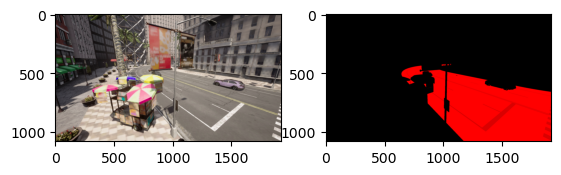

In [7]:
from matplotlib import pyplot as plt
import numpy as np

segm_gr = segm.copy()

segm_gr[(segm_gr != 7) & (segm_gr != 6)] = 0
segm_gr = segm_gr / np.max(segm_gr) * 255
segm_gr = np.array(segm_gr, dtype=np.uint8)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(image)
axes[1].imshow(segm_gr, cmap='gray')

[ 17  70  78  90 120 153 190]


TypeError: Invalid shape (3, 1024, 1024) for image data

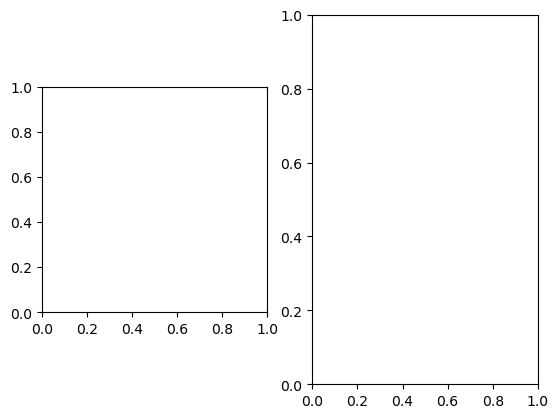

In [5]:
segm_gr = segm.copy()
segm_gr[segm_gr == 13] = 25
print(np.unique(segm_gr))
segm_gr = segm_gr / np.max(segm_gr) * 255
segm_gr = np.array(segm_gr, dtype=np.uint8)

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(image)
axes[1].imshow(segm_gr, cmap='gray')

In [18]:
import torch

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

In [19]:
next(iter(train_dataloader))

[tensor([[[[-0.6109, -0.6109, -0.5938,  ...,  0.7248,  0.7248,  0.7248],
           [-0.6281, -0.6281, -0.6281,  ...,  0.7248,  0.7248,  0.7248],
           [-0.6452, -0.6452, -0.6452,  ...,  0.7419,  0.7419,  0.7419],
           ...,
           [ 0.8618,  0.8618,  0.8618,  ...,  0.5022,  0.4851,  0.4679],
           [ 0.8447,  0.8447,  0.8447,  ...,  0.4508,  0.4337,  0.4166],
           [ 0.8276,  0.8276,  0.8276,  ...,  0.4337,  0.4337,  0.4166]],
 
          [[-0.5301, -0.5301, -0.5126,  ...,  0.9755,  0.9755,  0.9755],
           [-0.5301, -0.5301, -0.5301,  ...,  0.9580,  0.9580,  0.9580],
           [-0.5476, -0.5476, -0.5476,  ...,  0.9405,  0.9580,  0.9580],
           ...,
           [ 1.0980,  1.0980,  1.0980,  ...,  0.6604,  0.6604,  0.6604],
           [ 1.0805,  1.0980,  1.0805,  ...,  0.6254,  0.6078,  0.6078],
           [ 1.0630,  1.0630,  1.0805,  ...,  0.6254,  0.6078,  0.5903]],
 
          [[-0.3055, -0.3055, -0.2881,  ...,  1.3154,  1.3154,  1.3154],
           [-

In [20]:
from PIDNet.models.pidnet import get_pred_model, get_seg_model

model = get_seg_model(model_name='test',
                      path_to_pretrained='PIDNet\\pretrained_models\\cityscapes\\PIDNet_M_Cityscapes_val.pt',
                      num_classes=23, imgnet_pretrained=True)

In [21]:
from torch.optim import SGD
from PIDNet.utils.utils import FullModel
from PIDNet.utils.criterion import BondaryLoss, OhemCrossEntropy, CrossEntropy

device = torch.device('cuda')
class_weights = torch.FloatTensor([0.8373, 0.918, 0.866, 1.0345,
                                   1.0166, 0.9969, 0.9754, 1.0489,
                                   0.8786, 1.0023, 0.9539, 0.9843,
                                   1.1116, 0.9037, 1.0865, 1.0955,
                                   1.0865, 1.1529, 1.0507, 1,
                                   1, 1, 1]).to(device)

sem_criterion = OhemCrossEntropy(ignore_label=-1,
                                 thres=0.9,
                                 min_kept=131072,
                                 weight=class_weights)
# sem_criterion = CrossEntropy(ignore_label=-1, weight=class_weights)

bd_criterion = BondaryLoss()
model = FullModel(model, sem_criterion, bd_criterion).to(device)
optimizer = SGD(model.parameters(), lr=0.005)



torch.Size([8, 3, 1024, 1024]) torch.Size([8, 1024, 1024]) torch.Size([8, 1024, 1024])


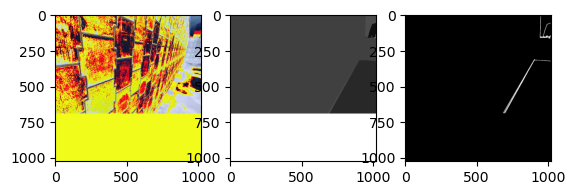

In [22]:
images, labels, bd_gts, _, _ = next(iter(train_dataloader))

labels_gr = labels.cpu().detach().numpy() / np.max(labels.cpu().detach().numpy()) * 255
labels_gr = np.array(labels_gr, dtype=np.uint8)

bd_gts_gr = bd_gts.cpu().detach().numpy() / np.max(bd_gts.cpu().detach().numpy()) * 255
bd_gts_gr = np.array(bd_gts_gr, dtype=np.uint8)

print(images.shape, labels.shape, bd_gts.shape)
fig, axes = plt.subplots(nrows=1, ncols=3)

picked_image = images[0] / torch.max(images[0]) * 255
picked_image = picked_image.to(torch.uint8)

picked_bd = bd_gts[0] / torch.max(bd_gts[0]) * 255
picked_bd = picked_bd.to(torch.uint8)


axes[0].imshow(picked_image.permute((1, 2, 0)).detach().cpu().numpy())
axes[1].imshow(labels[0].detach().cpu().numpy(), cmap='gray')
axes[2].imshow(bd_gts[0].detach().cpu().numpy(), cmap='gray')

In [23]:
from torch.nn import functional as F
import cv2
pred_model = model.model
pred_model.load_state_dict(torch.load('best.pt'))
pred_labels = pred_model(images.cuda())[0][0]

image = F.softmax(pred_labels, dim=0)
pred_one_labels = torch.argmax(image, dim=0).cpu().detach().numpy()

c_mask = torch.zeros((23, 128, 128))

for i in range(23):
    c_mask[i, pred_one_labels == i] = 1

pred_one_labels = pred_one_labels / np.max(pred_one_labels) * 255
pred_one_labels = np.array(pred_one_labels, dtype=np.uint8)

image = cv2.resize(pred_one_labels, (1024, 1024))
plt.imshow(image)

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 8.00 GiB total capacity; 7.10 GiB already allocated; 0 bytes free; 7.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import torchvision
from torchvision.utils import draw_segmentation_masks

c_mask = c_mask.to(torch.bool)
c_mask = torchvision.transforms.Resize(size=(1024, 1024))(c_mask)
print(picked_bd.shape, picked_image.shape)
picked_bd = torch.unsqueeze(picked_bd, dim=0)
picked_bd = torch.concat([picked_bd, picked_bd, picked_bd], dim=0)

mask_img = draw_segmentation_masks(picked_image, c_mask, alpha=0.5)

plt.imshow(mask_img.permute((1, 2, 0)).detach().cpu().numpy())

In [ ]:

import os
from tqdm import tqdm
from PIDNet.utils.function import train, validate
import torch.backends.cudnn as cudnn

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
EPOCHS = 200
epoch_iters = len(train_dataloader)
num_iters = EPOCHS * epoch_iters
cudnn.benchmark = True
cudnn.deterministic = False
cudnn.enabled = True

best_mIoU = 0
real_end = 200

for epoch in range(EPOCHS):
    train(epoch=epoch + 1, num_epoch=EPOCHS, epoch_iters=len(train_dataloader), base_lr=0.01, num_iters=num_iters,
          trainloader=train_dataloader, optimizer=optimizer, model=model)
    valid_loss, mean_IoU, IoU_array = validate(test_dataloader, model)

    if mean_IoU > best_mIoU:
        best_mIoU = mean_IoU
        torch.save(model.model.state_dict(),
                   os.path.join('checkpoints', 'best.pt'))

In [11]:
pred_model = model.model
pred_model.load_state_dict(torch.load('checkpoints/best.pt'))

<All keys matched successfully>

In [12]:
image, segm = next(train_dataset)

image_t = torch.tensor(image).permute(2, 0, 1) / 255
image_t = torch.unsqueeze(image_t, dim=0)
segm_gr = segm.copy()
segm_gr = segm_gr / np.max(segm_gr) * 255
segm_gr = np.array(segm_gr, dtype=np.uint8)
pred_model.eval()
out = pred_model(image_t.cuda())

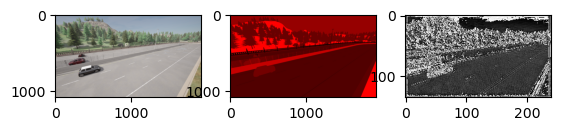

In [14]:
mask = (out[0] * 255).to(torch.uint8)
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].imshow(image)
axes[1].imshow(segm_gr, cmap='gray')
axes[2].imshow(mask[0][13].detach().cpu().numpy(), cmap='gray')

In [12]:
import random
import shutil
from tqdm import tqdm
import os

PATH = f'data/town/'

new_dataset_path = os.path.join('data', 'formatted_dataset')
os.mkdir(new_dataset_path)

img_dir = os.path.join(new_dataset_path, 'img_dir')
ann_dir = os.path.join(new_dataset_path, 'ann_dir')

os.mkdir(img_dir)
os.mkdir(ann_dir)

new_dataset_train_path_img = os.path.join(img_dir, 'train')
new_dataset_test_path_img = os.path.join(img_dir, 'test')
new_dataset_val_path_img = os.path.join(img_dir, 'val')
os.mkdir(new_dataset_train_path_img)
os.mkdir(new_dataset_test_path_img)
os.mkdir(new_dataset_val_path_img)


new_dataset_train_path_ann = os.path.join(ann_dir, 'train')
new_dataset_test_path_ann = os.path.join(ann_dir, 'test')
new_dataset_val_path_ann = os.path.join(ann_dir, 'val')
os.mkdir(new_dataset_train_path_ann)
os.mkdir(new_dataset_test_path_ann)
os.mkdir(new_dataset_val_path_ann)

towns_path = os.listdir(PATH)

for town_name in towns_path:
    town_path = os.path.join(PATH, town_name)
    waypoints = os.listdir(town_path)
    with tqdm(total=len(waypoints)) as t:
        for waypoint in waypoints:
            waypoint_path = os.path.join(town_path, waypoint)
            images_path = os.path.join(waypoint_path, 'rgb')
            masks_path = os.path.join(waypoint_path, 'seg')
            image_list = os.listdir(images_path)
            mask_list = os.listdir(masks_path)
            for image in image_list:
                train_test_val = random.randint(0, 10)
                new_image_name = image.replace('_rgb', '')
                new_image_name = new_image_name.replace('.', '_img.')

                if train_test_val <= 7:
                    copy_path_img = new_dataset_train_path_img
                    copy_path_ann = new_dataset_train_path_ann
                elif train_test_val <= 9:
                    copy_path_img = new_dataset_test_path_img
                    copy_path_ann = new_dataset_test_path_ann
                else:
                    copy_path_img = new_dataset_val_path_img
                    copy_path_ann = new_dataset_val_path_ann

                shutil.copy2(os.path.join(images_path, image), os.path.join(copy_path_img, new_image_name))
                seg_file = image.replace('rgb', 'seg')
                seg_file = seg_file.replace('.', '_color.')
                new_seg_name = new_image_name.replace('_img', '_mask')
                shutil.copy2(os.path.join(masks_path, seg_file), os.path.join(copy_path_ann, new_seg_name))

            t.set_description_str(f'Town: {town_name} | Waypoint: {waypoint}')
            t.update(1)


Town: Town03 | Waypoint: waypoint_99: 100%|██████████| 169/169 [00:12<00:00, 13.27it/s]
Town: Town05 | Waypoint: waypoint_99: 100%|██████████| 156/156 [00:12<00:00, 12.88it/s]
Town: Town07 | Waypoint: waypoint_99: 100%|██████████| 123/123 [00:12<00:00, 10.04it/s]
Town: Town10 | Waypoint: waypoint_99: 100%|██████████| 106/106 [00:15<00:00,  6.89it/s]


In [ ]:
data = dict(
    samples_per_gpu=4,
    workers_per_gpu=4,
    train=dict(
        type='ADE20KDataset',
        data_root='data/ade/ADEChallengeData2016',
        img_dir='images/training',
        ann_dir='annotations/training',
        pipeline=train_pipeline),
    val=dict(
        type='ADE20KDataset',
        data_root='data/ade/ADEChallengeData2016',
        img_dir='images/validation',
        ann_dir='annotations/validation',
        pipeline=test_pipeline),
    test=dict(
        type='ADE20KDataset',
        data_root='data/ade/ADEChallengeData2016',
        img_dir='images/validation',
        ann_dir='annotations/validation',
        pipeline=test_pipeline))